In [13]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold._utils import _binary_search_perplexity
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [2]:
def _joint_probabilities(distances, desired_perplexity):
    distances = distances.astype(np.float32, copy=False)
    conditional_P = _binary_search_perplexity(
        distances, None, desired_perplexity, False)
    P = conditional_P + conditional_P.T
    sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
    P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    return P

In [3]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30
learning_rate = 200
n_iter = 1000
min_grad_norm = 1e-7
n_iter_without_progress = 300
init = 'random'
random_state = np.random.mtrand._rand

In [4]:
def fit(X):
    n_samples = X.shape[0]
    
    neighbors_nn = None
    
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    P = _joint_probabilities(distances, perplexity)
    
    X_embedded = 1e-4 * random_state.randn(n_samples, n_components).astype(np.float32)
    
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded, neighbors=neighbors_nn)

In [5]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    
    PQd = squareform((P - Q) * dist)
    
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c

    return kl_divergence, grad

In [6]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded, neighbors=None):

    opt_args = {
        'args': [P, degrees_of_freedom, n_samples, n_components]
    }

    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
#     params, kl_divergence, it = _gradient_descent(obj_func, params, n_samples, n_components, degrees_of_freedom)
    params, kl_divergence, it = _gradient_descent(obj_func, params, **opt_args)
        
    X_embedded = params.reshape(n_samples, n_components)

    return X_embedded

In [7]:
def _gradient_descent(objective, p0, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, args=None, kwargs=None):
    
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0

        error, grad = objective(p, *args, **kwargs)

        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        
        print("[t-SNE] Iteration %d: error = %.7f,"
                  " gradient norm = %.7f"
                  % (i + 1, error, grad_norm))

        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break

    return p, error, i

In [8]:
X, y = load_digits(return_X_y=True)

In [10]:
W_projections = fit(X)

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000050
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000049
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000059
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000089
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000148
[t-SNE] Iteration 6: error = 4.0229674, gradient norm = 0.0000266
[t-SNE] Iteration 7: error = 4.0229668, gradient norm = 0.0000509
[t-SNE] Iteration 8: error = 4.0229644, gradient norm = 0.0001036
[t-SNE] Iteration 9: error = 4.0229531, gradient norm = 0.0002225
[t-SNE] Iteration 10: error = 4.0228959, gradient norm = 0.0005027
[t-SNE] Iteration 11: error = 4.0225771, gradient norm = 0.0011888
[t-SNE] Iteration 12: error = 4.0206464, gradient norm = 0.0029095
[t-SNE] Iteration 13: error = 4.0084841, gradient norm = 0.0070025
[t-SNE] Iteration 14: error = 3.9416874, gradient norm = 0.0138805
[t-SNE] Iteration 15: error = 3.7207402, gradient norm = 0.0179868
[t-S

[t-SNE] Iteration 125: error = 0.9398574, gradient norm = 0.0004980
[t-SNE] Iteration 126: error = 0.9378891, gradient norm = 0.0005041
[t-SNE] Iteration 127: error = 0.9359381, gradient norm = 0.0005223
[t-SNE] Iteration 128: error = 0.9339741, gradient norm = 0.0005215
[t-SNE] Iteration 129: error = 0.9319972, gradient norm = 0.0005127
[t-SNE] Iteration 130: error = 0.9300147, gradient norm = 0.0005079
[t-SNE] Iteration 131: error = 0.9280508, gradient norm = 0.0004934
[t-SNE] Iteration 132: error = 0.9261756, gradient norm = 0.0004892
[t-SNE] Iteration 133: error = 0.9244066, gradient norm = 0.0005271
[t-SNE] Iteration 134: error = 0.9226377, gradient norm = 0.0005395
[t-SNE] Iteration 135: error = 0.9208376, gradient norm = 0.0005195
[t-SNE] Iteration 136: error = 0.9190679, gradient norm = 0.0004821
[t-SNE] Iteration 137: error = 0.9173839, gradient norm = 0.0004736
[t-SNE] Iteration 138: error = 0.9157434, gradient norm = 0.0004693
[t-SNE] Iteration 139: error = 0.9141099, gradie

[t-SNE] Iteration 247: error = 0.8075352, gradient norm = 0.0002762
[t-SNE] Iteration 248: error = 0.8071488, gradient norm = 0.0002692
[t-SNE] Iteration 249: error = 0.8067624, gradient norm = 0.0002343
[t-SNE] Iteration 250: error = 0.8063771, gradient norm = 0.0002364
[t-SNE] Iteration 251: error = 0.8059909, gradient norm = 0.0002386
[t-SNE] Iteration 252: error = 0.8056058, gradient norm = 0.0002139
[t-SNE] Iteration 253: error = 0.8052285, gradient norm = 0.0002175
[t-SNE] Iteration 254: error = 0.8048568, gradient norm = 0.0002027
[t-SNE] Iteration 255: error = 0.8044917, gradient norm = 0.0002121
[t-SNE] Iteration 256: error = 0.8041294, gradient norm = 0.0002028
[t-SNE] Iteration 257: error = 0.8037696, gradient norm = 0.0001884
[t-SNE] Iteration 258: error = 0.8034131, gradient norm = 0.0002011
[t-SNE] Iteration 259: error = 0.8030578, gradient norm = 0.0001963
[t-SNE] Iteration 260: error = 0.8027043, gradient norm = 0.0001978
[t-SNE] Iteration 261: error = 0.8023503, gradie

[t-SNE] Iteration 369: error = 0.7764307, gradient norm = 0.0001168
[t-SNE] Iteration 370: error = 0.7762374, gradient norm = 0.0001216
[t-SNE] Iteration 371: error = 0.7760440, gradient norm = 0.0001226
[t-SNE] Iteration 372: error = 0.7758533, gradient norm = 0.0001338
[t-SNE] Iteration 373: error = 0.7756699, gradient norm = 0.0001602
[t-SNE] Iteration 374: error = 0.7755000, gradient norm = 0.0001945
[t-SNE] Iteration 375: error = 0.7753434, gradient norm = 0.0001851
[t-SNE] Iteration 376: error = 0.7751882, gradient norm = 0.0001507
[t-SNE] Iteration 377: error = 0.7750205, gradient norm = 0.0001865
[t-SNE] Iteration 378: error = 0.7748522, gradient norm = 0.0001365
[t-SNE] Iteration 379: error = 0.7746996, gradient norm = 0.0001725
[t-SNE] Iteration 380: error = 0.7745362, gradient norm = 0.0001631
[t-SNE] Iteration 381: error = 0.7743692, gradient norm = 0.0001456
[t-SNE] Iteration 382: error = 0.7742110, gradient norm = 0.0001466
[t-SNE] Iteration 383: error = 0.7740521, gradie

[t-SNE] Iteration 491: error = 0.7604281, gradient norm = 0.0000852
[t-SNE] Iteration 492: error = 0.7603258, gradient norm = 0.0000862
[t-SNE] Iteration 493: error = 0.7602236, gradient norm = 0.0000833
[t-SNE] Iteration 494: error = 0.7601215, gradient norm = 0.0000885
[t-SNE] Iteration 495: error = 0.7600194, gradient norm = 0.0000873
[t-SNE] Iteration 496: error = 0.7599175, gradient norm = 0.0000849
[t-SNE] Iteration 497: error = 0.7598157, gradient norm = 0.0000841
[t-SNE] Iteration 498: error = 0.7597140, gradient norm = 0.0000829
[t-SNE] Iteration 499: error = 0.7596123, gradient norm = 0.0000831
[t-SNE] Iteration 500: error = 0.7595107, gradient norm = 0.0000824
[t-SNE] Iteration 501: error = 0.7594093, gradient norm = 0.0000884
[t-SNE] Iteration 502: error = 0.7593078, gradient norm = 0.0000889
[t-SNE] Iteration 503: error = 0.7592063, gradient norm = 0.0000852
[t-SNE] Iteration 504: error = 0.7591050, gradient norm = 0.0000887
[t-SNE] Iteration 505: error = 0.7590037, gradie

[t-SNE] Iteration 613: error = 0.7500833, gradient norm = 0.0000723
[t-SNE] Iteration 614: error = 0.7500149, gradient norm = 0.0000785
[t-SNE] Iteration 615: error = 0.7499464, gradient norm = 0.0000762
[t-SNE] Iteration 616: error = 0.7498780, gradient norm = 0.0000714
[t-SNE] Iteration 617: error = 0.7498099, gradient norm = 0.0000699
[t-SNE] Iteration 618: error = 0.7497420, gradient norm = 0.0000723
[t-SNE] Iteration 619: error = 0.7496741, gradient norm = 0.0000722
[t-SNE] Iteration 620: error = 0.7496065, gradient norm = 0.0000769
[t-SNE] Iteration 621: error = 0.7495389, gradient norm = 0.0000701
[t-SNE] Iteration 622: error = 0.7494715, gradient norm = 0.0000722
[t-SNE] Iteration 623: error = 0.7494043, gradient norm = 0.0000736
[t-SNE] Iteration 624: error = 0.7493371, gradient norm = 0.0000708
[t-SNE] Iteration 625: error = 0.7492702, gradient norm = 0.0000711
[t-SNE] Iteration 626: error = 0.7492038, gradient norm = 0.0000754
[t-SNE] Iteration 627: error = 0.7491375, gradie

[t-SNE] Iteration 735: error = 0.7428398, gradient norm = 0.0000942
[t-SNE] Iteration 736: error = 0.7427855, gradient norm = 0.0000687
[t-SNE] Iteration 737: error = 0.7427319, gradient norm = 0.0000728
[t-SNE] Iteration 738: error = 0.7426784, gradient norm = 0.0000849
[t-SNE] Iteration 739: error = 0.7426244, gradient norm = 0.0000688
[t-SNE] Iteration 740: error = 0.7425711, gradient norm = 0.0000760
[t-SNE] Iteration 741: error = 0.7425179, gradient norm = 0.0000834
[t-SNE] Iteration 742: error = 0.7424643, gradient norm = 0.0000643
[t-SNE] Iteration 743: error = 0.7424113, gradient norm = 0.0000692
[t-SNE] Iteration 744: error = 0.7423586, gradient norm = 0.0000719
[t-SNE] Iteration 745: error = 0.7423058, gradient norm = 0.0000661
[t-SNE] Iteration 746: error = 0.7422534, gradient norm = 0.0000696
[t-SNE] Iteration 747: error = 0.7422010, gradient norm = 0.0000668
[t-SNE] Iteration 748: error = 0.7421489, gradient norm = 0.0000714
[t-SNE] Iteration 749: error = 0.7420967, gradie

[t-SNE] Iteration 857: error = 0.7363177, gradient norm = 0.0000988
[t-SNE] Iteration 858: error = 0.7362593, gradient norm = 0.0000773
[t-SNE] Iteration 859: error = 0.7362015, gradient norm = 0.0000786
[t-SNE] Iteration 860: error = 0.7361437, gradient norm = 0.0000836
[t-SNE] Iteration 861: error = 0.7360855, gradient norm = 0.0000719
[t-SNE] Iteration 862: error = 0.7360277, gradient norm = 0.0000843
[t-SNE] Iteration 863: error = 0.7359692, gradient norm = 0.0000747
[t-SNE] Iteration 864: error = 0.7359108, gradient norm = 0.0000740
[t-SNE] Iteration 865: error = 0.7358523, gradient norm = 0.0000756
[t-SNE] Iteration 866: error = 0.7357934, gradient norm = 0.0000706
[t-SNE] Iteration 867: error = 0.7357345, gradient norm = 0.0000798
[t-SNE] Iteration 868: error = 0.7356752, gradient norm = 0.0000777
[t-SNE] Iteration 869: error = 0.7356158, gradient norm = 0.0000832
[t-SNE] Iteration 870: error = 0.7355560, gradient norm = 0.0000923
[t-SNE] Iteration 871: error = 0.7354971, gradie

[t-SNE] Iteration 979: error = 0.7258570, gradient norm = 0.0001008
[t-SNE] Iteration 980: error = 0.7256621, gradient norm = 0.0001112
[t-SNE] Iteration 981: error = 0.7254593, gradient norm = 0.0001195
[t-SNE] Iteration 982: error = 0.7252485, gradient norm = 0.0001053
[t-SNE] Iteration 983: error = 0.7250306, gradient norm = 0.0001227
[t-SNE] Iteration 984: error = 0.7248036, gradient norm = 0.0001204
[t-SNE] Iteration 985: error = 0.7245677, gradient norm = 0.0001120
[t-SNE] Iteration 986: error = 0.7243257, gradient norm = 0.0001131
[t-SNE] Iteration 987: error = 0.7240753, gradient norm = 0.0001136
[t-SNE] Iteration 988: error = 0.7238163, gradient norm = 0.0001178
[t-SNE] Iteration 989: error = 0.7235468, gradient norm = 0.0001136
[t-SNE] Iteration 990: error = 0.7232651, gradient norm = 0.0001138
[t-SNE] Iteration 991: error = 0.7229688, gradient norm = 0.0001202
[t-SNE] Iteration 992: error = 0.7226558, gradient norm = 0.0001236
[t-SNE] Iteration 993: error = 0.7223220, gradie

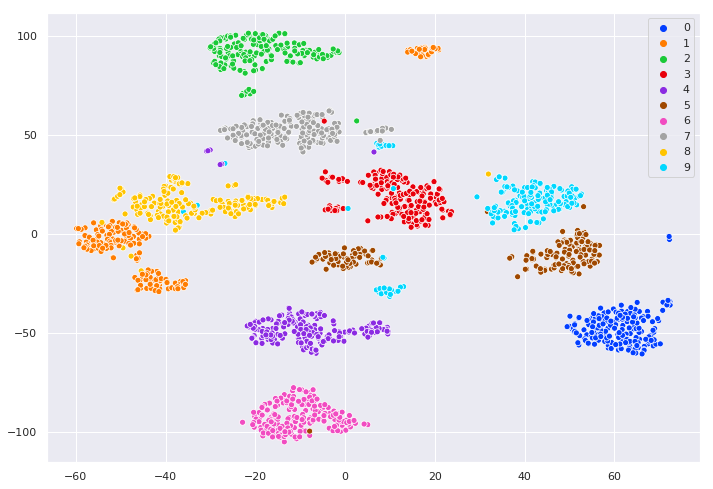

In [14]:
palette = sns.color_palette("bright", 10)

sns.scatterplot(W_projections[:,0], W_projections[:,1], hue=y, legend='full', palette=palette)

In [ ]:
tsne = TSNE()

In [ ]:
X_projection = tsne.fit_transform(X)

In [ ]:


sns.scatterplot(X_projection[:,0], X_projection[:,1], hue=y, legend='full', palette=palette)

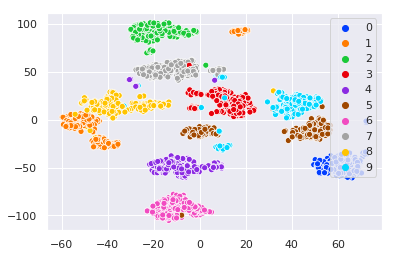